In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
train_loader

NameError: name 'train_loader' is not defined

In [5]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

Using downloaded and verified file: ../data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...


/home/bijanadmin/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


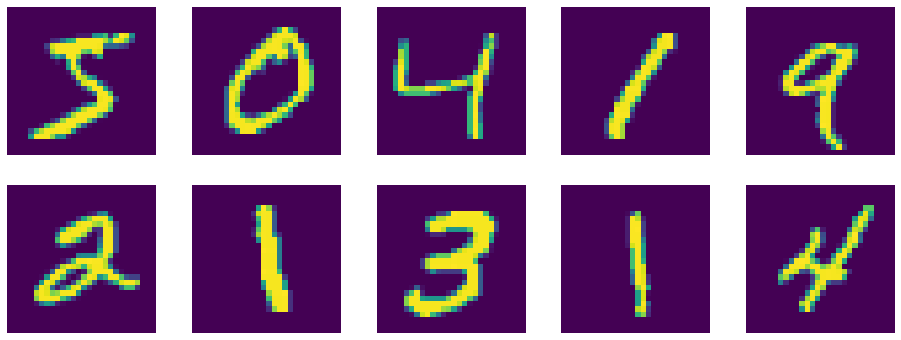

In [6]:
# show some images
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

In [7]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, self.n_feature*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [8]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, perm=torch.arange(0, 784).long()):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [9]:
# Training settings 
n_features = 6 # number of feature maps
model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.293344
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.980413
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.490233
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.360355
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.335995
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.187963
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.285773
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.191977
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.173604
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.107799

Test set: Average loss: 0.1691, Accuracy: 9464/10000 (95%)



In [70]:
import pdb

In [73]:
del y_NN
y_NN

NameError: name 'y_NN' is not defined

In [ ]:
x, y = next(iter(test_loader))
x = x[i].resize(1,1,28,28).to(device)
y = y[i].to(device)
#break

x.requires_grad_()
pdb.set_trace()
y_NN = model_cnn(x)
pred = y_NN
y_NN = y_NN[:,y_NN.argmax()]
model_cnn.zero_grad()
y_NN.backward()

saliency = (x.grad[0,0]).cpu().detach().numpy()
x = (x[0,0]).cpu().detach().numpy()

plt.figure()
plt.subplot(121)
plt.imshow(x)
# plt.title('ypred= ' + str(pred.argmax().item()))
plt.subplot(122)
plt.imshow(abs(saliency))


--Return--
None
> <ipython-input-74-3853fd41bc50>(7)<module>()
      5 
      6 x.requires_grad_()
----> 7 pdb.set_trace()
      8 y_NN = model_cnn(x)
      9 pred = y_NN

ipdb> pred
tensor([[-12.1151,  -7.0525,  -5.2566,  -5.8126, -12.1663, -11.7638, -17.4388,
          -0.0306,  -6.6573,  -3.9256]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
ipdb> type(y_NN)
*** NameError: name 'y_NN' is not defined
ipdb> y_NN
*** NameError: name 'y_NN' is not defined
ipdb> y_NN = model_cnn(x)
ipdb> type(y_NN)
<class 'torch.Tensor'>
ipdb> y_NN.size
<built-in method size of Tensor object at 0x7f3b8c583100>
ipdb> y_NN.shape
torch.Size([1, 10])
ipdb> pred = y_NN
ipdb> y_NN.argmax()
tensor(5, device='cuda:0')
ipdb> y_NN[:,y_NN.argmax()]
tensor([-0.0555], device='cuda:0', grad_fn=<SelectBackward>)
ipdb> y_NN[0:2]
tensor([[-11.0569, -15.5202, -14.1813,  -3.2818, -15.2796,  -0.0555, -18.5511,
          -7.7437,  -7.6756,  -4.1656]], device='cuda:0',
       grad_fn=<SliceBackward>)
ipdb> y_NN[1,1:

In [31]:
for name, param in model_cnn.named_parameters():
    if param.requires_grad:
        print(name, param.data)

conv1.weight tensor([[[[-2.2331e-04, -1.0911e-02,  1.5592e-01,  1.6545e-01, -4.1556e-02],
          [-9.1188e-02, -1.9459e-01, -6.7612e-02, -1.5871e-01, -2.3156e-01],
          [-1.6779e-01,  1.3460e-02, -1.9595e-01, -2.2499e-01,  7.5800e-02],
          [-4.8462e-02, -1.7529e-01,  7.8565e-02, -4.2303e-02,  6.0542e-02],
          [-7.6119e-02, -1.9032e-01,  1.5822e-01,  1.2173e-01, -1.3099e-01]]],


        [[[ 2.0983e-01,  4.5293e-01,  4.6560e-01,  1.9188e-01, -2.3639e-01],
          [ 1.2538e-01,  5.4999e-01,  4.1882e-01,  5.5609e-02, -2.4960e-01],
          [ 3.3565e-01,  4.6151e-01,  2.9731e-01,  3.8671e-02, -1.0298e-01],
          [ 9.2367e-02,  4.5197e-02, -1.0047e-03, -1.0127e-01,  1.8044e-01],
          [ 4.4412e-02,  4.5974e-02,  2.3693e-01,  1.2282e-01,  1.0638e-01]]],


        [[[ 1.8776e-01,  3.3323e-04,  5.8619e-02, -1.2687e-01, -9.2653e-02],
          [-1.1425e-01, -4.2585e-02, -1.8858e-01, -2.2207e-01, -2.7172e-01],
          [-2.2561e-02,  1.3341e-01, -7.0328e-02,  1.63

In [44]:
import numpy as np
import pdb

In [45]:
# testing
model_cnn.eval()
for i in range(16):
    for x,y in test_loader:
       #break
        #with torch.no_grad():
        x = x[i].resize(1,1,28,28).to(device)
        y = y[i].to(device)
        #break
        
        x.requires_grad_()
        y_NN = model_cnn(x)
        pred = y_NN
        y_NN = y_NN[:,y_NN.argmax()]
        model_cnn.zero_grad()
        y_NN.backward()
        #loss = F.nll_loss(y_NN, y)
#         pdb.set_trace()
        saliency = (x.grad[0,0]).cpu().detach().numpy()
        x = (x[0,0]).cpu().detach().numpy()

     #   print(y.cpu().detach().numpy(), y_NN.cpu().detach().numpy())
       # print('loss = %.3e'%loss)
       # print(x.shape)
       # print(saliency.shape)

        #np.save('image3.npy',x)
       # np.save(f_map_out, saliency)
        plt.figure()
        plt.subplot(121)
        plt.imshow(x)
        plt.title('ypred= ' + str(pred.argmax().item()))
        plt.subplot(122)
        plt.imshow(abs(saliency))
        break

> <ipython-input-45-80deda0c8f2e>(19)<module>()
     17         #loss = F.nll_loss(y_NN, y)
     18         pdb.set_trace()
---> 19         saliency = (x.grad[0,0]).cpu().detach().numpy()
     20         x = (x[0,0]).cpu().detach().numpy()
     21 

ipdb> x
tensor([[[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,


ipdb> x.shape
torch.Size([1, 1, 28, 28])
ipdb> x.grad
tensor([[[[ 4.5261e-08,  4.0091e-08, -1.6088e-08, -7.3291e-08, -1.6755e-08,
           -4.1387e-07, -1.0503e-06, -9.7217e-07,  2.4070e-07,  1.0950e-06,
            6.7930e-07, -1.1091e-07,  1.7093e-06,  3.2928e-07,  1.6144e-07,
           -1.1910e-07,  1.8376e-06,  1.7239e-06, -1.0142e-06,  3.1243e-08,
           -6.5965e-07,  5.7234e-07,  1.2695e-06, -5.9723e-07, -6.4315e-07,
           -7.5802e-08,  2.6000e-08,  0.0000e+00],
          [ 8.9992e-09,  4.9680e-08, -4.2351e-08, -8.6002e-08,  2.5584e-08,
            4.4226e-09,  9.2940e-08,  4.9556e-07,  1.3947e-06,  1.9373e-06,
            5.7082e-07, -8.4352e-07, -6.8644e-07,  3.1204e-06, -3.0308e-06,
           -5.3222e-06, -6.9696e-06, -5.7745e-06, -5.6189e-06, -4.2689e-06,
           -4.3142e-06, -6.0432e-07, -1.8333e-06, -3.5224e-06, -2.9952e-06,
            3.5007e-07,  4.4450e-07,  0.0000e+00],
          [ 2.2897e-07, -1.8794e-07, -2.0866e-07, -6.8197e-07, -1.6313e-06,
        

ipdb> x.grad[0,0]
tensor([[ 4.5261e-08,  4.0091e-08, -1.6088e-08, -7.3291e-08, -1.6755e-08,
         -4.1387e-07, -1.0503e-06, -9.7217e-07,  2.4070e-07,  1.0950e-06,
          6.7930e-07, -1.1091e-07,  1.7093e-06,  3.2928e-07,  1.6144e-07,
         -1.1910e-07,  1.8376e-06,  1.7239e-06, -1.0142e-06,  3.1243e-08,
         -6.5965e-07,  5.7234e-07,  1.2695e-06, -5.9723e-07, -6.4315e-07,
         -7.5802e-08,  2.6000e-08,  0.0000e+00],
        [ 8.9992e-09,  4.9680e-08, -4.2351e-08, -8.6002e-08,  2.5584e-08,
          4.4226e-09,  9.2940e-08,  4.9556e-07,  1.3947e-06,  1.9373e-06,
          5.7082e-07, -8.4352e-07, -6.8644e-07,  3.1204e-06, -3.0308e-06,
         -5.3222e-06, -6.9696e-06, -5.7745e-06, -5.6189e-06, -4.2689e-06,
         -4.3142e-06, -6.0432e-07, -1.8333e-06, -3.5224e-06, -2.9952e-06,
          3.5007e-07,  4.4450e-07,  0.0000e+00],
        [ 2.2897e-07, -1.8794e-07, -2.0866e-07, -6.8197e-07, -1.6313e-06,
         -1.6461e-06, -1.9927e-06,  2.3802e-07,  1.7367e-06,  2.3753e-

ipdb> exit


BdbQuit: 

In [13]:
pred.argmax().item()

2